## Final Project - Student Predictive Model

#### Imports

In [4]:
import csv
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap        
import numpy as np
import scipy as sp
import random
import pandas as pd
from math import sqrt
from sklearn import datasets
from sklearn.svm import SVC 
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from itertools import compress, product

#### Import Data from CSV File

In [28]:
#Reading in Data
pre_processed_data = pd.read_csv('StudentsPerformance.csv', delimiter=',')
pre_processed_data.head(5)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


#### Global Constants

In [29]:
PARAMETER_ORDER = ['gender', 'race_ethnicity', 'parent_education', 'lunch', 'test_prep', 'math_score', 'reading_score', 'writing_score']

#### Helper Functions

In [30]:
def simple_plot(name, x_label, x, y_label, y):
    plt.scatter(x,y)
    plt.title(name)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
# Categorical to Numerical - Requires correct order - FIX  THIS
def convert_to_integer(data, intersect=True):
    preProcess = []
    if intersect:
        preProcess.append(1)

    for param in PARAMETER_ORDER:
        if param in data:
            if param in ['math_score', 'reading_score', 'writing_score']:
                preProcess.append(data[param])
            else: 
                preProcess.append(integer_map[param][data[param]])
    return np.array(preProcess).reshape(1,-1)

def convert_to_onehot(data, intersect=True):
    preProcess = []
    if intersect:
        preProcess.append(1)

    for param in PARAMETER_ORDER:
        if param in data:
            if param in ['math_score', 'reading_score', 'writing_score']:
                preProcess.append(data[param])
            else: 
                preProcess.append(onehot_map[param][data[param]])

    postProcess = np.concatenate(([np.array(arr) for arr in preProcess]), axis=None)
    return postProcess.reshape(1,-1)

def convert_to_binary(data, intersect=True):
    preProcess = []
    if intersect:
        preProcess.append(1)

    for param in PARAMETER_ORDER:
        if param in data:
            if param in ['math_score', 'reading_score', 'writing_score']:
                preProcess.append(data[param])
            else: 
                preProcess.append(binary_map[param][data[param]])

    postProcess = np.concatenate(([np.array(arr) for arr in preProcess]), axis=None)
    return postProcess.reshape(1,-1)


#### Category Mapping (Integer Mapping)

In [31]:
integer_map = {

    # Gender Mapping
    'gender' : {
        'female' : 1,
        'male' : 0
    },

    # Race/Ethnicity Mapping
    'race_ethnicity' : {
        'group A' : 0,
        'group B' : 1,
        'group C' : 2,
        'group D' : 3,
        'group E' : 4
    },

    # Parental Education Mapping
    'parent_education' : {
        'some college' :        0,
        'associate\'s degree' : 1,
        'high school' :         2,
        'some high school' :    3,
        'bachelor\'s degree' :  4,
        'master\'s degree' :    5
    },

    # Lunch Mapping
    'lunch' : {
        'standard' : 0,
        'free/reduced' : 1
    },
    
    # Test Prep Mapping
    'test_prep' : {
        'none' : 0,
        'completed' : 1
    }
}

#### One Hot Encoding

In [32]:
onehot_map = {
    # Gender Mapping
    'gender' : {
        'female' : [1, 0],
        'male' : [0, 1]
    },

    # Race/Ethnicity Mapping
    'race_ethnicity' : {
        'group A' : [1, 0, 0, 0, 0],
        'group B' : [0, 1, 0, 0, 0],
        'group C' : [0, 0, 1, 0, 0],
        'group D' : [0, 0, 0, 1, 0],
        'group E' : [0, 0, 0, 0, 1]
    },

    # Parental Education Mapping
    'parent_education' : {
        'some college' :        [1, 0, 0, 0, 0, 0],
        'associate\'s degree' : [0, 1, 0, 0, 0, 0],
        'high school' :         [0, 0, 1, 0, 0, 0],
        'some high school' :    [0, 0, 0, 1, 0, 0],
        'bachelor\'s degree' :  [0, 0, 0, 0, 1, 0],
        'master\'s degree' :    [0, 0, 0, 0, 0, 1]
    },

    # Lunch Mapping
    'lunch' : {
        'standard' : [1, 0],
        'free/reduced' : [0, 1]
    },

    # Test Prep Mapping
    'test_prep' : {
        'none' : [1, 0],
        'completed' : [0, 1]
    }
}

#### Binary Encoding

In [33]:
binary_map = {
    # Gender Mapping
    'gender' : {
        'female' : [0],
        'male' : [1]
    },

    # Race/Ethnicity Mapping
    'race_ethnicity' : {
        'group A' : [0, 0, 0],
        'group B' : [0, 0, 1],
        'group C' : [0, 1, 0],
        'group D' : [0, 1, 1],
        'group E' : [1, 0, 0]
    },

    # Parental Education Mapping
    'parent_education' : {
        'some college' :        [0, 0, 0],
        'associate\'s degree' : [0, 0, 1],
        'high school' :         [0, 1, 0],
        'some high school' :    [0, 1, 1],
        'bachelor\'s degree' :  [1, 0, 0],
        'master\'s degree' :    [1, 0, 1]
    },

    # Lunch Mapping
    'lunch' : {
        'standard' : [0],
        'free/reduced' : [1]
    },

    # Test Prep Mapping

    'test_prep' : {
        'none' : [0],
        'completed' : [1]
    }
}

#### Encoding Data

In [34]:
#Pre-Processed Individual Data
math = np.array(pre_processed_data["math score"])
reading = np.array(pre_processed_data["reading score"])
writing = np.array(pre_processed_data['writing score'])
gender = np.array(pre_processed_data['gender'])
race_ethnicity = np.array(pre_processed_data['race/ethnicity'])
parent_education = np.array(pre_processed_data['parental level of education'])
lunch = np.array(pre_processed_data['lunch'])
test_prep = np.array(pre_processed_data['test preparation course'])

pre_processed_data_map = {
    'gender': gender, 
    'race_ethnicity': race_ethnicity, 
    'parent_education': parent_education, 
    'lunch': lunch, 
    'test_prep': test_prep, 
    'math_score': math, 
    'reading_score': reading, 
    'writing_score': writing
}

# Processed 
average_score = (math + reading + writing) / 3
intersect = np.ones(len(average_score))

# MAPPED DATA MATRICIES

N = len(average_score)

#Integer Mapped
integer_mapped_data_matrix = np.vstack(([convert_to_integer({'gender':gender[i],
                                                          'race_ethnicity':race_ethnicity[i],
                                                          'parent_education':parent_education[i],
                                                          'lunch':lunch[i],
                                                          'test_prep':test_prep[i]}) for i in range(N)]))

#One Hot Encoded
onehot_mapped_data_matrix = np.vstack(([convert_to_onehot({'gender':gender[i],
                                                          'race_ethnicity':race_ethnicity[i],
                                                          'parent_education':parent_education[i],
                                                          'lunch':lunch[i],
                                                          'test_prep':test_prep[i]}) for i in range(N)]))

#Binary Encoded
binary_mapped_data_matrix = np.vstack(([convert_to_binary({'gender':gender[i],
                                                          'race_ethnicity':race_ethnicity[i],
                                                          'parent_education':parent_education[i],
                                                          'lunch':lunch[i],
                                                          'test_prep':test_prep[i]}) for i in range(N)]))

integer_reg = LinearRegression().fit(integer_mapped_data_matrix, average_score)
onehot_reg = LinearRegression().fit(onehot_mapped_data_matrix, average_score)
binary_reg = LinearRegression().fit(binary_mapped_data_matrix, average_score)

dict1 = {'gender':'female', 
            'race_ethnicity':'group B', 
            'parent_education':'bachelor\'s degree', 
            'lunch':'standard', 
            'test_prep':'none'}

dict2 = {'gender':'male', 
            'race_ethnicity':'group A', 
            'parent_education':'associate\'s degree', 
            'lunch':'free/reduced', 
            'test_prep':'none'}

integer_converted1 = convert_to_integer(dict1)
onehot_converted1 = convert_to_onehot(dict1)
binary_converted1 = convert_to_binary(dict1)

integer_converted_2 = convert_to_integer(dict2)
onehot_converted2 = convert_to_onehot(dict2)
binary_converted2 = convert_to_binary(dict2)

print('INTEGER')
print(integer_reg.predict(integer_converted1))
print(integer_reg.predict(integer_converted_2))

print('ONEHOT')
print(onehot_reg.predict(onehot_converted1))
print(onehot_reg.predict(onehot_converted2))

print('BINARY')
print(binary_reg.predict(binary_converted1))
print(binary_reg.predict(binary_converted2))

print(sum(average_score)/len(average_score))

INTEGER
[68.29569006]
[52.58197253]
ONEHOT
[72.1418988]
[55.57797034]
BINARY
[72.61428369]
[55.01559059]
67.77066666666664


#### Visualizing a 2-Dimensional Plot With Classes (Classification)

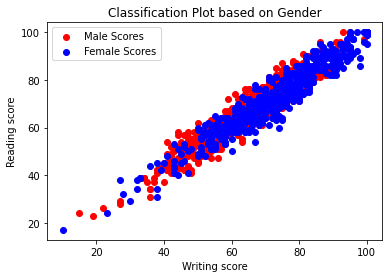

In [35]:
GENDER_COL = 0
RACE_COL = 1
PARENTAL_EDU_COL = 2
LUNCH_COL = 3
TEST_PREP_COL = 4
MATH_SCORE_COL = 5
READING_SCORE_COL = 6
WRITING_SCORE_COL = 7

def class_plot(class_name, class1, class2, feature1, feature2):
    plt.scatter(pre_processed_data[feature1][(class_name == class1) | (class_name == class1)],
            pre_processed_data[feature2][(class_name == class1) | (class_name == class1)],
           color='red',
           label=class1.capitalize() + " Scores")
    plt.scatter(pre_processed_data[feature1][class_name == class2],
            pre_processed_data[feature2][class_name == class2],
           color='blue',
           label=class2.capitalize() + " Scores")

    plt.title("Classification Plot based on " + class_name.name.capitalize())
    plt.xlabel(feature1.capitalize())
    plt.ylabel(feature2.capitalize())
    plt.legend()
    
class_plot(pre_processed_data.gender, 'male', 'female', 'writing score', 'reading score')

#### Comparing Integer vs. Binary vs. One-Hot Encoding

In [36]:
import warnings
warnings.filterwarnings('ignore')
class K_Fold():
    def __init__(self, X, y, k):
        self.X = X
        self.y = y
        self.k = k
        
    def k_fold_test(self):
        #Split up data into folds
        listX = np.array_split(self.X, self.k, axis=0)
        listY = np.array_split(self.y, self.k)

        #Set up Model
        model = LinearRegression()
        
        #get average accuracy
        total = 0
        for i in range(self.k):
            #Partition matricies to use
            training_X = np.vstack(np.delete(listX, i, 0))
            training_Y = np.vstack(np.delete(listY, i, 0))
            
            model.fit(training_X, np.ravel(training_Y))
            y_pred = model.predict(listX[i])
            error = mean_squared_error(y_pred, listY[i])
            total += error

        return total/self.k

Performing k-fold cross validation for each encoding method... 

Integer encoding yields an error of 164.13236
One-hot encoding yields an error of 160.25044
Binary encoding yields an error of 156.85448


Text(0.5, 1.0, 'Error for each Encoding Method')

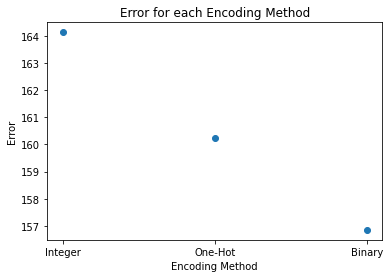

In [37]:
# Split into test and train data and shuffle (80/20 split)
int_x_shuffled, int_y_shuffled = shuffle(integer_mapped_data_matrix, average_score)
binary_x_shuffled, binary_y_shuffled = shuffle(binary_mapped_data_matrix, average_score)
OH_x_shuffled, OH_y_shuffled = shuffle(onehot_mapped_data_matrix, average_score)

x_int_train, x_int_test, y_int_train, y_int_test = train_test_split(int_x_shuffled, int_y_shuffled, test_size = 0.2, random_state = 37)
x_binary_train, x_binary_test, y_binary_train, y_binary_test = train_test_split(binary_x_shuffled, binary_y_shuffled, test_size = 0.2, random_state = 37)
x_OH_train, x_OH_test, y_OH_train, y_OH_test = train_test_split(OH_x_shuffled, OH_y_shuffled, test_size = 0.2, random_state = 37)

int_reg = LinearRegression().fit(x_int_train, y_int_train)
OH_reg = LinearRegression().fit(x_OH_train, y_OH_train)
binary_reg = LinearRegression().fit(x_binary_train, y_binary_train)

# Create K-Fold Classes for each Encoding Method
kf_int = K_Fold(int_x_shuffled, int_y_shuffled, k=5)
kf_OH = K_Fold(OH_x_shuffled, OH_y_shuffled, k=5)
kf_binary = K_Fold(binary_x_shuffled, binary_y_shuffled, k=5)

int_error = round(kf_int.k_fold_test(), 5)
OH_error = round(kf_OH.k_fold_test(), 5)
binary_error = round(kf_binary.k_fold_test(), 5)

print('Performing k-fold cross validation for each encoding method... \n')
print('Integer encoding yields an error of ' + str(int_error))
print('One-hot encoding yields an error of ' + str(OH_error))
print('Binary encoding yields an error of ' + str(binary_error))

encoding_y = [int_error, OH_error, binary_error]
encoding_x = ['Integer', 'One-Hot', 'Binary']

plt.scatter(encoding_x, encoding_y)
plt.ylabel('Error')
plt.xlabel('Encoding Method')
plt.title('Error for each Encoding Method')

#### Feature Reduction

In [38]:
# Feature reduction function
def reduce_features(original_x_data, y_data, orig_index_dict):
    lowest_index, lowest_error = 0, 0
    num_rows, num_cols = original_x_data.shape

    for n in range(1,num_cols):
        reduced_data_matrix = np.delete(original_x_data, (n), axis=1)
        x_red_train, x_red_test, y_red_train, y_red_test = train_test_split(reduced_data_matrix, y_data, test_size = 0.2, random_state = 37)
        error = K_Fold(reduced_data_matrix, int_y_shuffled, k = 5).k_fold_test()
        if n is 1:
            lowest_index = 1
            lowest_error = error
        else:
            if error < lowest_error:
                lowest_index = n
                lowest_error = error
    new_x_data = np.delete(original_x_data, (lowest_index), axis=1)
    
    new_index_dict = {key:val for key, val in orig_index_dict.items() if val != lowest_index}
    
    # Reorder dictionary values from 1-n consecutive
    counter = 1
    for key, value in new_index_dict.items():
        new_index_dict[key] = counter
        counter += 1
        
    return lowest_index, lowest_error, new_x_data, new_index_dict

In [39]:
orig_dict = {
    'GENDER' : 1,
    'RACE' : 2,
    'PARENTAL EDUCATION' : 3,
    'FREE LUNCH' : 4,
    'TEST PREP' : 5}

x_data = int_x_shuffled
y_data = int_y_shuffled

lowest_index1, lowest_error1, new_data_matrix1, index_dict1 = reduce_features(x_data, y_data, orig_dict)
feature_removed1 = list(orig_dict.keys())[list(orig_dict.values()).index(lowest_index1)]

lowest_index2, lowest_error2, new_data_matrix2, index_dict2 = reduce_features(new_data_matrix1, y_data, index_dict1)
feature_removed2 = list(index_dict1.keys())[list(index_dict1.values()).index(lowest_index2)]

lowest_index3, lowest_error3, new_data_matrix3, index_dict3 = reduce_features(new_data_matrix2, y_data, index_dict2)
feature_removed3 = list(index_dict2.keys())[list(index_dict2.values()).index(lowest_index3)]

lowest_index4, lowest_error4, new_data_matrix4, index_dict4 = reduce_features(new_data_matrix3, y_data, index_dict3)
feature_removed4 = list(index_dict3.keys())[list(index_dict3.values()).index(lowest_index4)]

# Data matrix now only contains a column of 1's
lowest_index5, lowest_error5, new_data_matrix5, index_dict5 = reduce_features(new_data_matrix4, y_data, index_dict4)
feature_removed5 = list(index_dict4.keys())[list(index_dict4.values()).index(lowest_index5)]

print('The order of feature importance is as follows')
print('1) ' + feature_removed5)
print('2) ' + feature_removed4)
print('3) ' + feature_removed3)
print('4) ' + feature_removed2)
print('5) ' + feature_removed1)

The order of feature importance is as follows
1) FREE LUNCH
2) TEST PREP
3) RACE
4) GENDER
5) PARENTAL EDUCATION


Error with all features included: 164.13236

Features included: FREE LUNCH, TEST PREP, RACE, GENDER
Error: 164.3008

Features included: FREE LUNCH, TEST PREP, RACE
Error: 167.46648

Features included: FREE LUNCH, TEST PREP
Error: 172.81473

Features included: FREE LUNCH
Error: 186.72028

Features included: None
Error: 203.35525


Text(0.5, 1.0, 'Error as we reduce features')

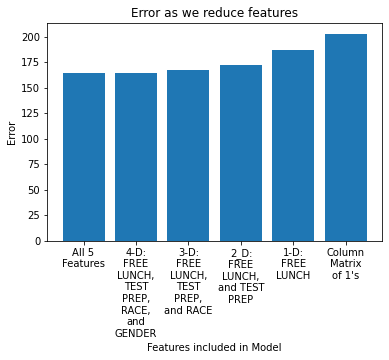

In [40]:
# Visualizing how error changes as we reduce features
from textwrap import wrap

print('Error with all features included: ' + str(int_error))
print()
print('Features included: ' + feature_removed5 + ', ' + feature_removed4 + 
      ', ' + feature_removed3 + ', ' + feature_removed2)
print('Error: ' + str(round(lowest_error1, 5)))
print()
print('Features included: ' + feature_removed5 + ', ' + feature_removed4 + ', ' + feature_removed3)
print('Error: ' + str(round(lowest_error2, 5)))
print()
print('Features included: ' + feature_removed5 + ', ' + feature_removed4)
print('Error: ' + str(round(lowest_error3, 5)))
print()
print('Features included: ' + feature_removed5)
print('Error: ' + str(round(lowest_error4, 5)))
print()
print('Features included: None')
print('Error: ' + str(round(lowest_error5, 5)))

n_1 = str('4-D: ' + feature_removed5 + ', ' + feature_removed4 + ', ' + feature_removed3 + ', and ' + feature_removed2)
n_2 = str('3-D: ' + feature_removed5 + ', ' + feature_removed4 + ', and ' + feature_removed3)
n_3 = str('2_D: ' + feature_removed5 + ', and ' + feature_removed4)
n_4 = str('1-D: ' + feature_removed5)
n_5 = 'Column Matrix of 1\'s'

error_plot_y = [int_error, lowest_error1, lowest_error2, lowest_error3, lowest_error4, lowest_error5]
error_plot_x = ['All 5 Features', n_1, n_2, n_3, n_4, n_5]
error_plot_x = [ '\n'.join(wrap(label, 8)) for label in error_plot_x]

plt.bar(error_plot_x, error_plot_y)
plt.ylabel('Error')
plt.xlabel('Features included in Model')
plt.title('Error as we reduce features')

# LDA Classification

In [62]:
#Pre-Processed Individual Data
math = np.array(pre_processed_data["math score"])
reading = np.array(pre_processed_data["reading score"])
writing = np.array(pre_processed_data['writing score'])
gender = np.array(pre_processed_data['gender'])
race_ethnicity = np.array(pre_processed_data['race/ethnicity'])
parent_education = np.array(pre_processed_data['parental level of education'])
lunch = np.array(pre_processed_data['lunch'])
test_prep = np.array(pre_processed_data['test preparation course'])

stacked_data = np.column_stack((gender, race_ethnicity, parent_education, lunch, test_prep, math, reading, writing))

#Partitioning if needed. 
X_train, X_test, Y_train, Y_test = train_test_split(stacked_data, np.zeros(len(math)), test_size=.1)

training_data_map = {
    'gender': X_train[:,0], 
    'race_ethnicity': X_train[:,1], 
    'parent_education': X_train[:,2], 
    'lunch': X_train[:,3], 
    'test_prep': X_train[:,4], 
    'math_score': X_train[:,5], 
    'reading_score': X_train[:,6], 
    'writing_score': X_train[:,7]
}

test_data_map = {
    'gender': X_test[:,0], 
    'race_ethnicity': X_test[:,1], 
    'parent_education': X_test[:,2], 
    'lunch': X_test[:,3], 
    'test_prep': X_test[:,4], 
    'math_score': X_test[:,5], 
    'reading_score': X_test[:,6], 
    'writing_score': X_test[:,7]
}

In [63]:
def combinations(items) -> set:
    return ( set(compress(items,mask)) for mask in product(*[[0,1]]*len(items)) )

class OmniDirectional_Model():

    def __init__(self, encoding_type='integer'):
        self.convert_to = {'onehot': convert_to_onehot, 'integer': convert_to_integer, 'binary': convert_to_binary}[encoding_type]
        self.model_dict = dict()

        given_input_combinations = list(combinations(PARAMETER_ORDER))
        given_input_combinations.remove(set())
        all_output_possibilities = set(PARAMETER_ORDER)

        for given in given_input_combinations:
            given_lst = list(given)
            goals = list(all_output_possibilities.difference(given))
            for goal in goals:
                self.model_dict[self.generate_key(given_lst, goal)] = self.generate_model_with(given_lst, goal)

    
    def generate_key(self, given_params: list, goal: str):
        key_str = ""
        for i in range(len(PARAMETER_ORDER)):
            if PARAMETER_ORDER[i] in given_params:
                key_str += str(i)
        key_str += "-" + str(PARAMETER_ORDER.index(goal))
        return key_str


    def generate_model_with(self, given_params: list, goal: str):
        main_data_array = np.column_stack(([
            training_data_map[param] for param in given_params
        ]))

        converted_list = []

        is_linear = (True if goal in ['math_score', 'reading_score', 'writing_score'] else False)

        for row in main_data_array:
            temp_dict = {}
            for i in range(len(given_params)):
                temp_dict[given_params[i]] = row[i]
            converted_list.append(self.convert_to(temp_dict, intersect=is_linear))

        converted_params_array = np.vstack(converted_list)

        if is_linear:
            return LinearRegression().fit(converted_params_array, training_data_map[goal])
        else:
            return LinearDiscriminantAnalysis().fit(converted_params_array, training_data_map[goal])
    

    def predict_fields(self, given_dict):  
        goals = [i for i in PARAMETER_ORDER]
        for key, _ in given_dict.items():
            goals.remove(key)

        predictions = {}

        for goal in goals:
            model_to_use = self.generate_key(given_dict, goal)
            has_intersect = (True if goal in ['math_score', 'reading_score', 'writing_score'] else False)
            prediction = self.model_dict[model_to_use].predict(self.convert_to(given_dict, intersect=has_intersect))
            predictions[goal] = prediction[0]
        
        return predictions
    

In [64]:
test_model = OmniDirectional_Model()

In [44]:
print(test_model.predict_fields({
    'race_ethnicity': 'group B',
    'parent_education': 'bachelor\'s degree',
    'lunch': 'standard',
    'test_prep': 'none',
    'math_score': 72,
    'reading_score': 72,
    'writing_score': 74
    }))

print(test_model.predict_fields({
    'race_ethnicity': 'group C',
    'parent_education': 'some college',
    'lunch': 'standard',
    'test_prep': 'completed',
    'math_score': 69,
    'reading_score': 90,
    'writing_score': 88
    }))

print(test_model.predict_fields({
    'race_ethnicity': 'group A',
    'lunch': 'free/reduced',
    'test_prep': 'none',
    'reading_score': 57
    }))


{'gender': 'female'}
{'gender': 'female'}
{'gender': 'female', 'parent_education': 'high school', 'math_score': 50.43752792716756, 'writing_score': 54.08303609646916}


In [65]:
feature_dict = {
    'gender' : 1,
    'race_ethnicity' : 2,
    'parent_education' : 3,
    'lunch' : 4,
    'test_prep' : 5,
    'math_score' : 6,
    'reading_score' : 7,
    'writing_score' : 8
}

# Orig_Data is original unencoded data, index_lst are the indices for the variables we know
def get_dict(orig_data, index_lst):
    output_dict = []
    y = []
    for data_point in orig_data:
        dict_point = {list(feature_dict.keys())[list(feature_dict.values()).index(i)]: data_point[i-1] for i in index_lst}
        output_dict.append(dict_point)
        temp_dict = {}
        for i in range(len(data_point)):
            if PARAMETER_ORDER[i] not in dict_point:
                temp_dict[PARAMETER_ORDER[i]] = data_point[i]
        y.append(temp_dict)
    return output_dict, y

In [70]:
raw_data = pre_processed_data.to_numpy()
features_lst = [1, 2, 3, 4, 5, 6, 7, 8]


for i in range(1, 9):
    features_to_test = [j for j in features_lst]
    features_to_test.remove(i)
    dict_lst, y = get_dict(X_test, features_to_test)

    correct = 0
    for k in range(len(dict_lst)):
        if i in [6, 7, 8]:
            if abs(test_model.predict_fields(dict_lst[k])[PARAMETER_ORDER[i - 1]] - y[k][PARAMETER_ORDER[i - 1]]) < 4:
                correct += 1
        else:
            if test_model.predict_fields(dict_lst[k]) == y[k]:
                correct += 1
    print('Testing ' + str(PARAMETER_ORDER[i - 1]))
    print(float(correct) / len(dict_lst))

features_lst = [2, 3, 4, 6, 7, 8]

dict_lst, y = get_dict(X_test, features_lst)

correct = 0
for k in range(len(dict_lst)):
    if test_model.predict_fields(dict_lst[k]) == y[k]:
        correct += 1
print('Testing 5, 1')
print(float(correct) / len(dict_lst))


Testing 1
0.89
Testing 2
0.35
Testing 3
0.3
Testing 4
0.68
Testing 5
0.69
Testing 6
0.57
Testing 7
0.62
Testing 8
0.66
Testing 5, 1
0.58
